##### Copyright 2018 The TensorFlow Authors.

In [100]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [101]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()
np.set_printoptions(precision=3, suppress=True)

Import `matplotlib` and create a helper function to plot graphs:

In [102]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


[11781, 28981]


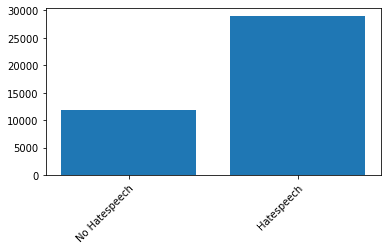

<Figure size 1152x432 with 0 Axes>

In [130]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


#
# Load the csv data.
#
def load_data_arrays():
    df_1 = pd.read_csv("datasets/1_no_stopwords.csv")
    df_3 = pd.read_csv("datasets/3_no_stopwords.csv")
    
#    df_5 = pd.read_csv("datasets/5_no_stopwords.csv")
    
    df_6 = pd.read_csv("datasets/6_no_stopwords.csv")
    
    df = df_1.append(df_3)
    df = df.append(df_6)
    
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df["is_hatespeech"])
    
    return train_df, test_df

def plot_data_distribution(labels_1, label_2):
    total = labels_1.reshape(-1).tolist()
    total.extend(label_2.reshape(-1).tolist())
    bins = sorted(list(set(total)))

    plt.bar(bins, [total.count(bin_val) for bin_val in bins])
    print([total.count(bin_val) for bin_val in bins])
    plt.xticks(bins,
               ["No Hatespeech", "Hatespeech"],
               rotation=45,
               rotation_mode="anchor",
               ha="right")

    plt.subplots_adjust(bottom=0.3)
    plt.figure(figsize=(16, 6))
    plt.show()

train_df, test_df = load_data_arrays()


plot_data_distribution(train_df['is_hatespeech'].values, test_df['is_hatespeech'].values)

In [104]:
# Convert the test- and train-DataFrames to Tensorflow Datasets

train_labels = np.eye(2)[train_df['is_hatespeech'].values]
train_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(np.asarray(train_df['text'].values, dtype=str), tf.string),
            tf.cast(train_labels, tf.int32)
        )
    )
)

test_labels = np.eye(2)[test_df['is_hatespeech'].values]
test_dataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(np.asarray(test_df['text'].values, dtype=str), tf.string),
            tf.cast(test_labels, tf.int32)
        )
    )
)

Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [105]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

In [106]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [107]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy())
  print()
  print('labels: ', label.numpy())

texts:  [b'some ice melted car cause dumb fuck 711 decided wanted strike conversation wit fat ugly bitch smfh'
 b'dat bitch wild shit lls' b'shut fuck faggot'
 b'it takes true directioner accept larry you know bitch fans like make boys cry thankyoupaulforconfirminglarry'
 b'yourewelcomeexe'
 b'rt first graders asked photo mike brown such innocence'
 b'home chicken penne alfredo oreos banjo'
 b'why artist new ones making much trash' b'pussy'
 b'rt bitch benito i thought i one'
 b'the rich kids beverly hills trash even entertaining trash and look mid thirties'
 b'canelo still bounces big mongoloid'
 b'responses bad ive got block list enabled i see nothing'
 b'thank much we another shithole country full violence hate arrogantu2026'
 b'rt i promise last thing wanna bitch sister front me dont poke lion'
 b'rt rt watching bird poop car got washed' b'whats next fingers dykes'
 b'miss sysinstall'
 b'rt katampandre monday people voted strategically rude katampandre tonight votes strategically t

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [108]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency: 

In [109]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'i', 'rt', 'bitch', 'like', 'im', 'mkr', 'bitches',
       'hoes', 'pussy', 'get', 'hoe', 'you', 'fuck', 'ass', 'got', 'u',
       'shit', 'amp'], dtype='<U27')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [110]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[331, 775,   1, 333, 133, 136,  14,   1,   1, 454,   1,   1, 139,
        165, 182,   4,   1],
       [181,   4,   1,  18,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0],
       [188,  14,  34,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0]], dtype=int64)

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [111]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'some ice melted car cause dumb fuck 711 decided wanted strike conversation wit fat ugly bitch smfh'
Round-trip:  some ice [UNK] car cause dumb fuck [UNK] [UNK] wanted [UNK] [UNK] wit fat ugly bitch [UNK]

Original:  b'dat bitch wild shit lls'
Round-trip:  dat bitch [UNK] shit [UNK]            

Original:  b'shut fuck faggot'
Round-trip:  shut fuck faggot              



## Create the model

Above is a diagram of the model. 

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output. 

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output. 


The code to implement this is below:

In [133]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_10 (Embedding)    (None, None, 64)          64000     
                                                                 
 bidirectional_13 (Bidirecti  (None, 128)              66048     
 onal)                                                           
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 2)                 130       
                                                                 
Total params: 138,434
Trainable params: 138,434
Non-tr

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [113]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [114]:
# predict on a sample text without padding.

sample_text = ('How are you doing')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[0.5 0.5]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [115]:
# predict on a sample text with padding

padding = "How are you doing " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[0.5 0.5]


Compile the Keras model to configure the training process:

In [116]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

## Train the model

In [117]:
history = model.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=10)

Epoch 1/5
510/510 [==============================] - 40s 74ms/step - loss: 0.4656 - accuracy: 0.7823 - val_loss: 0.2829 - val_accuracy: 0.8750
Epoch 2/5
510/510 [==============================] - 35s 69ms/step - loss: 0.2356 - accuracy: 0.9048 - val_loss: 0.2532 - val_accuracy: 0.8984
Epoch 3/5
510/510 [==============================] - 35s 69ms/step - loss: 0.2113 - accuracy: 0.9159 - val_loss: 0.2478 - val_accuracy: 0.9047
Epoch 4/5
510/510 [==============================] - 35s 68ms/step - loss: 0.2014 - accuracy: 0.9181 - val_loss: 0.2454 - val_accuracy: 0.8984
Epoch 5/5
510/510 [==============================] - 35s 69ms/step - loss: 0.1963 - accuracy: 0.9207 - val_loss: 0.2428 - val_accuracy: 0.8969


In [118]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

128/128 [==============================] - 4s 30ms/step - loss: 0.2126 - accuracy: 0.9079
Test Loss: 0.21259935200214386
Test Accuracy: 0.9078866839408875


In [119]:
# Save the model
#!mkdir models
#model.save('rnn_one', save_format='tf')

(0.0, 0.47907222136855127)

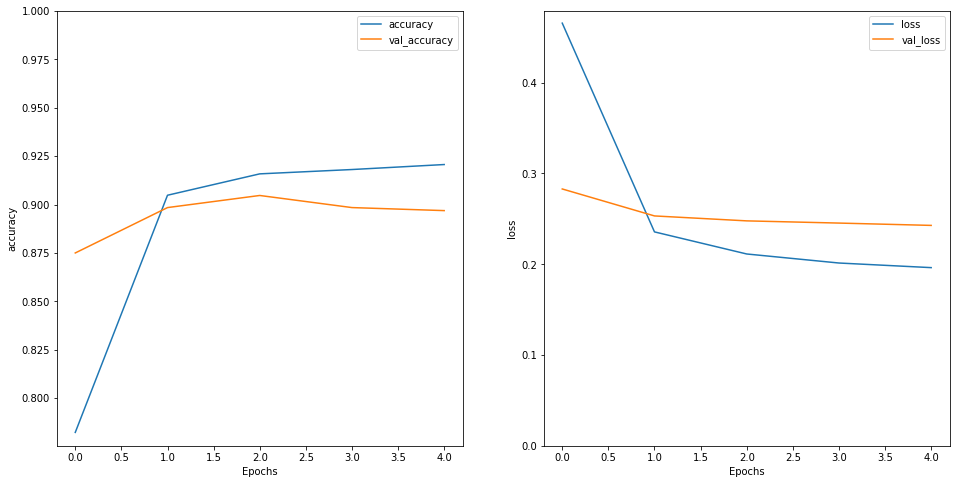

In [120]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [121]:
sample_text = ['That was very nice of you to say', 'You stupid fucking bitch']
predictions = model.predict(np.array(sample_text))
print(predictions)

[[0.893 0.107]
 [0.001 0.999]]


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](images/layered_bidirectional.png)

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [122]:
model_two = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

print(model_two.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_3 (TextV  (None, None)             0         
 ectorization)                                                   
                                                                 
 embedding_7 (Embedding)     (None, None, 64)          64000     
                                                                 
 bidirectional_10 (Bidirecti  (None, None, 128)        66048     
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                      

In [123]:
model_two.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(0.0001),
              metrics=['accuracy'])

In [124]:
history_two = model_two.fit(train_dataset, epochs=5,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/5
510/510 [==============================] - 40s 67ms/step - loss: 0.4478 - accuracy: 0.7919 - val_loss: 0.2555 - val_accuracy: 0.8938
Epoch 2/5
510/510 [==============================] - 32s 62ms/step - loss: 0.2421 - accuracy: 0.9043 - val_loss: 0.2240 - val_accuracy: 0.9094
Epoch 3/5
510/510 [==============================] - 32s 62ms/step - loss: 0.2181 - accuracy: 0.9148 - val_loss: 0.2140 - val_accuracy: 0.9115
Epoch 4/5
510/510 [==============================] - 32s 62ms/step - loss: 0.2076 - accuracy: 0.9182 - val_loss: 0.2098 - val_accuracy: 0.9120
Epoch 5/5
510/510 [==============================] - 32s 62ms/step - loss: 0.2010 - accuracy: 0.9220 - val_loss: 0.2104 - val_accuracy: 0.9094


In [125]:
test_loss, test_acc = model_two.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

128/128 [==============================] - 3s 27ms/step - loss: 0.2170 - accuracy: 0.9059
Test Loss: 0.2169739156961441
Test Accuracy: 0.9059242010116577


In [126]:
# predict on a sample text without padding.

sample_text = ['You are such a stupid fucking whore',
               'I would not recommend this movie.']
predictions = model_two.predict(np.array(sample_text))

print(predictions)

[[0.015 0.985]
 [0.819 0.181]]


In [127]:
# Save the model
!mkdir models
model_two.save('models/rnn_two')

Ein Unterverzeichnis oder eine Datei mit dem Namen "models" existiert bereits.


INFO:tensorflow:Assets written to: models/rnn_two\assets


INFO:tensorflow:Assets written to: models/rnn_two\assets


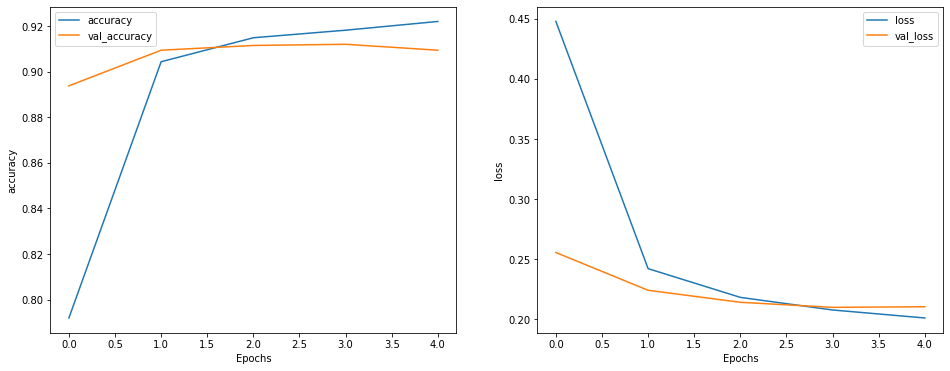

In [128]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history_two, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history_two, 'loss')

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interestied in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
